# A real-time deep learning approach to grain orientation mapping of anisotropic media for improved ultrasonic non-destructive evaluation


## Jonathan Singh  (jonathan.singh@strath.ac.uk)
### Cite as:  Singh J., Tant K., Mulholland A., Curtis A., (2021), A real-time deep learning approach to grain orientation mapping of anisotropic media for improved ultrasonic non-destructive evaluation. [insert ArXiv doi]

This notebook demonstrates a deep learning aproach to ultrasound tomography for reconstructing maps of grain orientations using deep neural networks (DNNs) and generative adversatial networks (GANs). This notebook accompanys the paper "A real-time deep learning approach to grain orientation mapping of anisotropic media for improved ultrasonic non-destructive evaluation". 

We recomend using Google colab free GPUs, which allows instant implementation without the need of install any additional packages.  

In this example, you will use ultrasonic time of flight data for a square sample using full aperture, pitch-catch and pulse echo transducer array configurations to train a DNN for ultrasound tomography and train a GAN to acheive factor-four super resolution. Some example results are shown below:


### Example output of the deep neural network reconstructing grain orientation
![configs.png](dnn_example.png)


### Example output of the GAN acheiving factor-four upscaling of resolution
![image.png](gan_example.png)


### Import libraries

In [10]:
import skopt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as tfk
from multiprocessing import Process, Queue
from scipy.io import loadmat
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display

### Load data
Import data from .mat files. The data consists of 7500 pairs of travel times (inputs) and grain orientation maps (outputs) for training, and 200 model-data pairs for testing. 
The training data is generated by smoothing a voronoi tesselation and computing travel times using the [anisotropic multi-stencil fast marching method](https://www.tandfonline.com/doi/full/10.1080/17415977.2020.1762596). 

Three tranduscer array configurations are used and pictured below: 
![configs](configs.png)

In [27]:
training_matlab = loadmat('anisoTrainingFastMarching16x16.mat')
inputs_true_fa = training_matlab['inputs']
outputs_true_fa = training_matlab['outputs']

training_matlab = loadmat('anisoTrainingFastMarchingPulseReflect16x16.mat')
inputs_true_pr = training_matlab['inputs']
outputs_true_pr = training_matlab['outputs']

training_matlab = loadmat('anisoTrainingFastMarchingPulseTrans16x16.mat')
inputs_true_pt = training_matlab['inputs']
outputs_true_pt = training_matlab['outputs']

training_matlab = loadmat('anisotTestAllAperture.mat')

inputs_fa_ns = training_matlab['inputs_fa']
inputs_pr_ns = training_matlab['inputs_pr']
inputs_pt_ns = training_matlab['inputs_pt']
outputs_all_ap = training_matlab['outputs']

The data is scaled to have a zero mean and unit variance

In [28]:
#Combine training and testing data so they are scaled by the same factor

inputs_true_fa=np.append(inputs_true_fa,(inputs_fa_ns),axis=0)
inputs_true_pt=np.append(inputs_true_pt,(inputs_pt_ns),axis=0)
inputs_true_pr=np.append(inputs_true_pr,(inputs_pr_ns),axis=0)
outputs_true_fa = np.append(outputs_true_fa,(outputs_all_ap),axis=0)

# reshape images into 1D 
outputs_true_fa=np.reshape(outputs_true_fa,(7700,256))
outputs_true_pt=np.reshape(outputs_true_pt,(7500,256))
outputs_true_pr=np.reshape(outputs_true_pr,(7500,256))

inputs_fa = preprocessing.scale(inputs_true_fa)
inputs_pr = preprocessing.scale(inputs_true_pr)
inputs_pt = preprocessing.scale(inputs_true_pt)

outputs_fa = preprocessing.scale(outputs_true_fa)
outputs_pt = preprocessing.scale(outputs_true_pt)
outputs_pr = preprocessing.scale(outputs_true_pr)


input_fa_test = inputs_fa[7500:7700,:]
input_pt_test = inputs_pt[7500:7700,:]
input_pr_test = inputs_pr[7500:7700,:]

output_all_test = outputs_fa[7500:7700,:]
inputs_fa=np.delete(inputs_fa,(np.arange(200)+7500),axis=0)
inputs_pt=np.delete(inputs_pt,(np.arange(200)+7500),axis=0)
inputs_pr=np.delete(inputs_pr,(np.arange(200)+7500),axis=0)
outputs_fa=np.delete(outputs_fa,(np.arange(200)+7500),axis=0)

In [16]:
x_train_fa,x_test_fa,y_train_fa,y_test_fa = train_test_split(inputs_fa,outputs_fa,test_size=0.01)
x_train_pt,x_test_pt,y_train_pt,y_test_pt = train_test_split(inputs_pt,outputs_pt,test_size=0.01)
x_train_pr,x_test_pr,y_train_pr,y_test_pr = train_test_split(inputs_pr,outputs_pr,test_size=0.01)

## DNN configurations

Configurations were optimised using [Scikit-Optimize](https://scikit-optimize.github.io/stable/) for [hyperparameter optimisation](https://machinelearningmastery.com/scikit-optimize-for-hyperparameter-tuning-in-machine-learning/). Optimal network parameters are described by netParams(adam learning rate, number of hidden layers, number of input nodes, number of nodes for hidden layers, activation function, batch size, adam decay rate).

Using a validation dataset (with validation split = 0.2), early stopping is implemented with patience=10. So training stops where the validation loss increases for over 10 epochs. The maximum number of epochs is 500.  



### Full aperture transucer array configuration

In [17]:
netParams = [0.0038824847512218914, 3, 315, 63, 'sigmoid', 80,0.0058864640772035735] #optim for full aperture

callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def create_model(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (96,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mse')
    
    history=model.fit(x=x_train_fa,
                    y=y_train_fa[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history


In [18]:
#train network for each pixel
modelMat_fa=[]

for i in tqdm(range(0,256)):
    modelOut=create_model(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_fa.append(modelOut)

100%|██████████████████████████████████████████████████████████████████████| 256/256 [34:42<00:00, 11.28s/it]


### Pulse reflection 

In [42]:
netParams = [0.005, 3, 353, 68, 'sigmoid', 78,0.0068] #optim for fmm pulse reflection

# set up early stopping
callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def create_model(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (136,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mse')
    
    history=model.fit(x=x_train_pr,
                    y=y_train_pr[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history


In [43]:
#train network for each pixel
modelMat_pr=[]

for i in tqdm(range(0,256)):
    modelOut=create_model(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_pr.append(modelOut)

100%|██████████████████████████████████████████████████████████████████████| 256/256 [59:00<00:00,  7.80s/it]


### Pulse transmission

In [44]:

netParams = [0.0025, 3, 345, 55, 'sigmoid', 50,0.00553] # 

callbacks = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def create_model(outCellInd,learning_rate, num_dense_layers,num_input_nodes,
                 num_dense_nodes, activation, batch_size, adam_decay):
    #start the model making process and create our first layer
    model = Sequential()
    model.add(Dense(num_input_nodes, input_shape= (256,), activation=activation
                   ))
    #create a loop making a new dense layer for the amount passed to this model.
    #naming the layers helps avoid tensorflow error deep in the stack trace.
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
    #add our classification layer.
    model.add(Dense(1))
    
    #setup our optimizer and compile
    adam = Adam(lr=learning_rate, decay= adam_decay)
    model.compile(optimizer=adam, loss='mse')
    
    history=model.fit(x=x_train_pt,
                    y=y_train_pt[:,outCellInd],
                    epochs=500,
                    callbacks=callbacks,
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.2
                    )
    return model,history


In [45]:
#train network for each pixel
modelMat_pt=[]

for i in tqdm(range(0,256)):
    modelOut=create_model(i,netParams[0],netParams[1],netParams[2],netParams[3],netParams[4],netParams[5],netParams[6])
    modelMat_pt.append(modelOut)

100%|████████████████████████████████████████████████████████████████████| 256/256 [3:22:24<00:00, 35.77s/it]


## Network Testing

DNNs for each tranduscer configuration have now been trained. Next take a dataset that has not been used in any part of training (input_fa_test,input_pt_test,input_pr_test). For comaprison, the same models (output_all_test) are used for the three transducer configurations. 


In [50]:
bMat_fa =[]
bMat_pr =[]
bMat_pt =[]

for i in range(0,256):
    # full aperture
    b = modelMat_fa[i][0].predict(input_fa_test)
    bMat_fa.append(b)

    # pulse reflection
    b = modelMat_pr[i][0].predict(input_pr_test)
    bMat_pr.append(b)

    # pulse transmission
    b = modelMat_pt[i][0].predict(input_pt_test)
    bMat_pt.append(b)
    

# convert results to numpy arrays
bMat_pr = np.array(bMat_pr)    
bMat_pt = np.array(bMat_pt)
bMat_fa = np.array(bMat_fa)

### Animate results

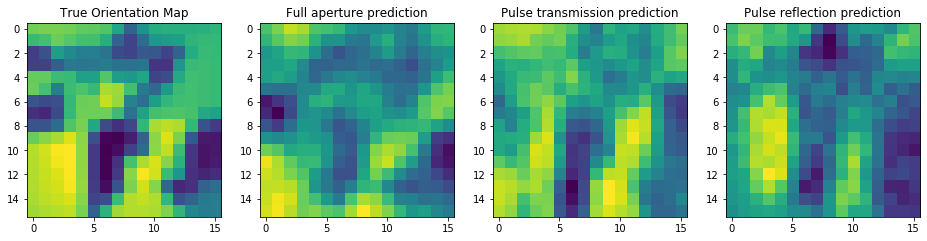

<Figure size 1152x576 with 0 Axes>

In [53]:
plt.figure(figsize=(16,8))
for i in range(200):
    xInd=i
    
    mod_pred_fa = np.reshape(bMat_fa[:,xInd],[16,16])
    mod_pred_pt = np.reshape(bMat_pt[:,xInd],[16,16])
    mod_pred_pr = np.reshape(bMat_pr[:,xInd],[16,16])
    
    mod_true = np.reshape(output_all_test[xInd,:],[16,16])

    plt.subplot(141)
    plt.imshow(mod_true)
    plt.title('True Orientation Map')
    
    plt.subplot(142)
    plt.imshow(mod_pred_fa)
    plt.title('Full aperture prediction')
    
    plt.subplot(143)
    plt.imshow(mod_pred_pt)
    plt.title('Pulse transmission prediction')
    
    plt.subplot(144)
    plt.imshow(mod_pred_pr)
    plt.title('Pulse reflection prediction')
    
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    
    time.sleep(0.5)
    pl.clf()

## GAN for super resolution and post processing tomography results
Generative adversarial networks (GANs) are powerful computer vision tools for image based problems. Here we use a GAN to take the low resolution (16x16) output of the DNN tomography described above, and output a 64x64 high resolution image of images with sharp discontiuous boundaries in grain orientation. A schematic of the GAN is shown below ![image.png](gan_schematic.png)

The GAN methodology presented here is a modification of the [pix2pix](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb#scrollTo=qmkj-80IHxnd) algorithm, to allow changes in image resolution. A copy of the License for this work can be found [here](https://www.apache.org/licenses/LICENSE-2.0).

### Get training data
The training data consits of:
* 64x64 resolution true models with discontinous grain boundaries
* Travel times from the AMSFMM methods using a full aperture transducer array configuration
* 16x16 tomographic reconstruction from the full aperture DNN 

The travel times and true models are stored in anisoTrainingFMM64x64_6seed.mat

In [57]:
training_matlab = loadmat('anisoTrainingFMM64x64_6seed.mat') 
inputs_trueHighRes  = training_matlab['inputs'] # inputs should be scaled with training data  
outputs_trueHighRes = training_matlab['outputs'] # doesn't need to be scaled in the same way

inputs_trueHighRes_scaled = preprocessing.scale(inputs_trueHighRes)
outputs_trueHighRes_scaled = (outputs_trueHighRes/22.5)-1

x_trainHR,x_testHR,y_trainHR,y_testHR = train_test_split(inputs_trueHighRes_scaled,outputs_trueHighRes_scaled,test_size=0.5)

In [59]:
# Use trained DNN to generate 16x16 images

bMatHR_test = []
bMatHR_train = []

for i in tqdm(range(0,256)):
    b = modelMat_fa[i][0].predict(x_testHR)
    bMatHR_test.append(b)
    
    b = modelMat_fa[i][0].predict(x_trainHR)
    bMatHR_train.append(b)

bMatHR_test = np.array(bMatHR_test)
bMatHR_train = np.array(bMatHR_train)


100%|██████████████████████████████████████████████████████████████████████| 256/256 [00:29<00:00,  8.94it/s]


In [61]:
bMatHR_train= bMatHR_train.transpose(1,0,2).reshape(1000,16,16)
bMatHR_test= bMatHR_test.transpose(1,0,2).reshape(1000,16,16)
np.shape(bMatHR_train)

(1000, 16, 16)

In [62]:
y_trainHR_HR = y_trainHR.repeat(4,axis=1).repeat(4,axis=2)
y_testHR_HR = y_testHR.repeat(4,axis=1).repeat(4,axis=2)

In [63]:
# convert arrays to tensors
input_train = tf.cast(bMatHR_train, tf.float32)
output_train = tf.cast(y_trainHR, tf.float32)

input_test = tf.cast(bMatHR_test, tf.float32)
output_test = tf.cast(y_testHR, tf.float32)

input_train = tf.reshape(input_train,(1000,16,16,1))
output_train = tf.reshape(output_train,(1000,64,64,1))

input_test = tf.reshape(input_test,(1000,16,16,1))
output_test = tf.reshape(output_test,(1000,64,64,1))

In [94]:
# create tensorflow datasets
BATCH_SIZE = 10
BUFFER_SIZE = 400

train_dataset = tf.data.Dataset.from_tensor_slices((input_train,output_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((input_test,output_test))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)

#### Plot example 16x16 - 64x64 image pairs

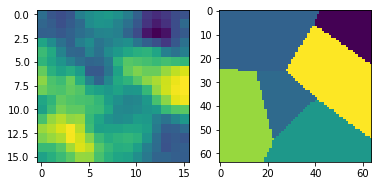

In [75]:
# randomly sample training data
ind = np.random.randint(1000)
plt.subplot(121)
plt.imshow(input_train[ind,:,:,0])

plt.subplot(122)
plt.imshow(output_train[ind,:,:,0])

### Build the Generator
Both the generator and discriminator are defined using the Keras Sequential API.

*   The architecture of generator is a modified U-Net.
*   Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
* Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
* There are skip connections between the encoder and decoder (as in U-Net).
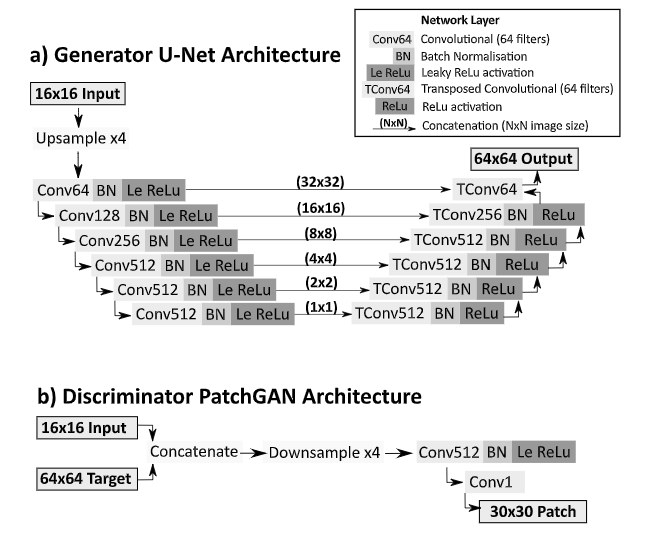

In [76]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [77]:
inp = tf.reshape(input_train[0],(16,16,1))
out = tf.reshape(output_train[0],(64,64,1))

In [78]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 8, 8, 3)


In [79]:
def upsampleimage():
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.UpSampling2D(size=(4,4), interpolation='nearest'))

  return result

In [80]:
up_model = upsampleimage()
up_result = up_model(down_result)
print (up_result.shape)

(1, 32, 32, 3)


In [81]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [82]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 16, 16, 3)


In [83]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[16,16,1])
  
  down_stack = [
    upsampleimage(), 
    downsample(64, 4, apply_batchnorm=False), # (bs, 32, 32, 64)
    downsample(128, 4), # (bs, 16, 16, 128)
    downsample(256, 4), # (bs, 8, 8, 256)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 64, 64, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [84]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Plot what generater outputs before training

Text(0.5, 1.0, 'Output')

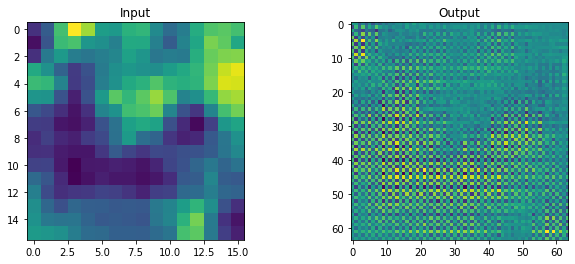

In [85]:
inp0 = tf.reshape(inp,(1,16,16,1))
gen_output = generator(inp0, training=False)
plt.subplot(121)
plt.imshow(inp0[0,:,:,0])
plt.title('Input')

plt.subplot(122)
gen_output = generator(inp0, training=False)
plt.imshow(gen_output[0,:,:,0])
plt.subplots_adjust(right=1.5)
plt.title('Output')

### Generator Loss


As in [pix2pix paper](https://arxiv.org/abs/1611.07004), the generator loss is : 
*   sigmoid cross entropy los of generated images and an **array of ones**
*also includes L1 loss (MAE) between generated and target image
* total generator loss = gan_loss + LAMBDA*L1_loss, where LAMBDA=100


In [86]:
LAMBDA = 50 # changed from 100
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Build the Discriminator 
*   Discriminator is a PatchGAN
*   Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
* The shape of the output after the last layer is (batch_size, 30, 30, 1). Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).


Discriminator receives 2 inputs.
*   Input image and the target image, which it should classify as real
*   Input image and the generated image (output of generator), which it should classify as fake.


In [87]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[16, 16, 1], name='input_image')
  inp2 = tf.keras.layers.UpSampling2D(size=(4,4),interpolation='nearest')(inp)

  tar = tf.keras.layers.Input(shape=[64, 64, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp2, tar]) # (bs, 64, 64, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 32, 32, 64)
 # down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down1) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


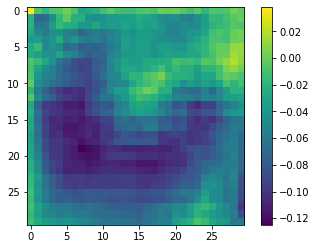

In [88]:
disc_out = discriminator( [inp0,gen_output], training=False)


plt.imshow(np.squeeze(disc_out))
plt.colorbar()

### Discriminator loss



*   takes 2 inputs: **real image** and **generated image**
*   real_loss is sigmoid cross entropy loss with real image and array of ones
*   gen_loss is sigmoid cross entropy loss with generated image and array of zeros

total loss = real_loss + gen_loss 


In [89]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [91]:

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### GAN Training
#### Prediction and Plotting Functions

In [96]:
def generate_images(model, test_input, tar,epoch):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0,:,:,0], tar[0,:,:,0], prediction[0,:,:,0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it. ## Why? 
   #  plt.imshow(display_list[i] * 0.5 + 0.5)
    
    im = plt.imshow(display_list[i] )
    if i==0:
      im.set_clim(-2,2)
    else:
      im.set_clim(-1,1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis()
 
  plt.show()

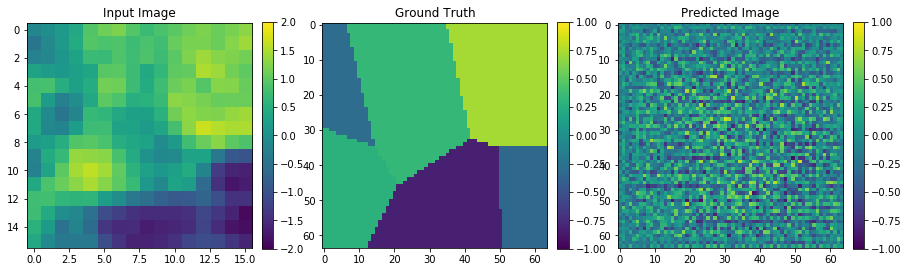

In [97]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target,1)

### Training
Calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.

In [99]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [100]:

def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [101]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target,0)
      
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 5 ==0: ############################   Change this number for how frequently you want figures
        display.clear_output(wait=True)
        
        for example_input, example_target in test_ds.take(1):
          generate_images(generator, example_input, example_target,epoch+n+1)
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()
  
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

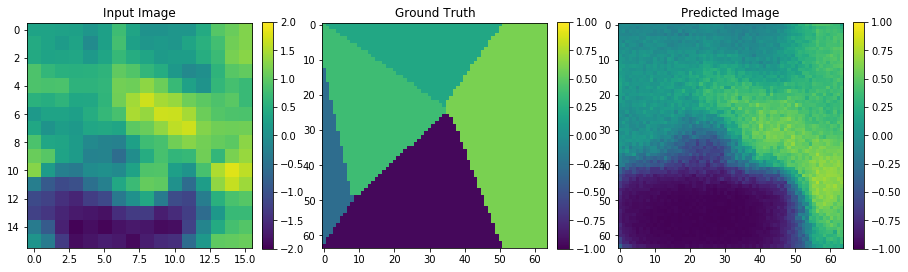



Time taken for epoch 1 is 479.81595969200134 sec



In [102]:
EPOCHS = 1 # Each epoch can take several minutes. 40 epochs were used for example results image 
fit(train_dataset, EPOCHS, test_dataset)